In [ ]:
!pip install fastbook

In [8]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [11]:
from fastai.vision.all import *
from fastai.data.external import untar_data, URLs
from fastbook import *

In [17]:
path = untar_data(URLs.MNIST)

In [18]:
Path.BASE_PATH = path

In [19]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [21]:
(path/'training').ls()

(#10) [Path('training/3'),Path('training/9'),Path('training/2'),Path('training/1'),Path('training/4'),Path('training/5'),Path('training/7'),Path('training/8'),Path('training/6'),Path('training/0')]

In [23]:
threes = (path/'training'/'3').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()

In [26]:
threes
im3 = Image.open(threes[1])
im3

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

# Pixel Similarity

In [31]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

<Axes: >

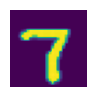

In [32]:
show_image(seven_tensors[0])

In [33]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [35]:
stacked_sevens.shape

torch.Size([6265, 28, 28])

<Axes: >

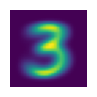

In [37]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

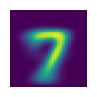

In [38]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [40]:
a_3 = stacked_threes[1]
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [43]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'7').ls()])

valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255


valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [44]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))

In [46]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1233, 0.1125, 0.1324,  ..., 0.1187, 0.1181, 0.1116]),
 torch.Size([1010]))

In [47]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [48]:
is_3(a_3)

tensor(True)

In [52]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# SGD

In [53]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [56]:
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

In [58]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [59]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [61]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [64]:
weights = init_params((28 * 28, 1))
bias = init_params(1)

In [69]:
weights

tensor([[ 1.6917e-02],
        [ 8.0277e-02],
        [ 7.4484e-01],
        [ 1.3455e+00],
        [ 1.2682e-01],
        [-2.4521e+00],
        [ 4.1598e-01],
        [ 1.9025e+00],
        [-7.3467e-01],
        [ 4.4657e-02],
        [-1.5211e+00],
        [ 3.4784e-01],
        [ 7.4018e-01],
        [ 1.4162e+00],
        [ 6.8340e-01],
        [-1.3825e-01],
        [ 9.2130e-01],
        [ 5.2824e-01],
        [-8.2284e-03],
        [-1.4493e+00],
        [-6.0518e-01],
        [-1.7925e-01],
        [ 1.9956e-01],
        [-1.2462e+00],
        [-4.1460e-01],
        [ 1.4559e+00],
        [ 3.3165e-01],
        [-1.0001e+00],
        [-6.9195e-01],
        [-4.7199e-01],
        [-1.2894e+00],
        [ 1.0763e+00],
        [-1.0667e+00],
        [-1.9893e+00],
        [ 2.9731e-01],
        [ 4.3446e-01],
        [ 3.3933e-03],
        [-1.0240e+00],
        [ 2.2405e-01],
        [-7.5548e-01],
        [ 1.3676e+00],
        [-3.1974e-01],
        [-9.1309e-01],
        [ 1

In [65]:
(train_x[0]*weights.T).sum() + bias

tensor([-3.8565], grad_fn=<AddBackward0>)

In [66]:
def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[-3.8565],
        [-5.0067],
        [-9.2098],
        ...,
        [-8.2678],
        [ 0.1213],
        [ 1.4608]], grad_fn=<AddBackward0>)

In [67]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]])

In [68]:
corrects.float().mean().item()

0.3957728445529938

In [70]:
with torch.no_grad(): weights[0] *= 1.001

In [71]:
preds = linear1(train_x)

In [72]:
((preds>0.0).float() == train_y).float().mean().item()

0.3957728445529938

In [75]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [90]:
weights = init_params(((28 * 28), 1))
bias = init_params(1)

In [91]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [92]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [93]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [94]:
preds = linear1(batch)

In [95]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.1797, grad_fn=<MeanBackward0>)

In [96]:
loss.backward()

In [97]:
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0072), tensor([-0.0506]))

In [98]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [99]:
calc_grad(batch, train_y[:4], linear1)

In [100]:
weights.grad.mean(), bias.grad

(tensor(-0.0144), tensor([-0.1012]))

In [103]:
def train_epoch(model, lr, params):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

In [104]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds > 0.5) == yb
  return correct.float().mean()

In [105]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [106]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [107]:
validate_epoch(linear1)

0.6895

In [109]:
lr = 1
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7724

In [110]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.8876 0.9193 0.9364 0.9413 0.9501 0.9535 0.9579 0.9589 0.9613 0.9623 0.9628 0.9637 0.9647 0.9647 0.9657 0.9662 0.9677 0.9677 0.9687 0.9682 

In [111]:
linear_model = nn.Linear(28*28,1)

In [113]:
w,b= linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [114]:
class BasicOptim:
  def __init__(self, params, lr): self.params,self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

In [115]:
opt = BasicOptim(linear_model.parameters(), lr)

In [116]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [117]:
validate_epoch(linear_model)

0.4294

In [118]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [119]:
train_model(linear_model, 20)

0.4932 0.8804 0.8237 0.9111 0.9336 0.9472 0.956 0.9624 0.9653 0.9673 0.9692 0.9717 0.9736 0.9751 0.9761 0.9765 0.977 0.978 0.978 0.979 

In [120]:
dls = DataLoaders(dl, valid_dl)

In [122]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [123]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636516,0.503525,0.495584,00:00
1,0.542777,0.157035,0.877331,00:00
2,0.198095,0.196590,0.818449,00:00
3,0.086359,0.111633,0.909225,00:00
4,0.045266,0.080120,0.932777,00:00
5,0.029282,0.063598,0.946025,00:00
6,0.022739,0.053494,0.955839,00:00
7,0.019846,0.046834,0.962218,00:00
8,0.018391,0.042174,0.965162,00:00
9,0.017523,0.038747,0.967125,00:00


In [124]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res

In [ ]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

In [125]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [126]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [127]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.304882,0.415397,0.504416,00:00
1,0.144067,0.228050,0.809617,00:00
2,0.080019,0.113638,0.916094,00:00
3,0.052708,0.076613,0.942100,00:00
4,0.040034,0.059891,0.957311,00:00
5,0.033562,0.050602,0.965162,00:00
6,0.029846,0.044792,0.965653,00:00
7,0.027433,0.040824,0.967125,00:00
8,0.025695,0.037931,0.968597,00:00
9,0.024346,0.035715,0.971050,00:00
